In [0]:
#danaderp May6'19
#Prediction For Main Issues Data Set

In [0]:
import csv
from tensorflow.keras.preprocessing import text
from nltk.corpus import gutenberg
from string import punctuation
from tensorflow.keras.preprocessing.sequence import skipgrams

/scratch/danaderp/.conda/envs/drmccr_conda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Limited tf.compat.v2.summary API due to missing TensorBoard installation
Limited tf.summary API due to missing TensorBoard installation


In [0]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
pd.options.display.max_colwidth = 200
%matplotlib inline

In [0]:
from nltk.stem.snowball import SnowballStemmer
englishStemmer=SnowballStemmer("english")

In [0]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Dot, Input, Dense, Reshape, LSTM, Conv2D, Flatten, MaxPooling1D, Dropout, MaxPooling2D
from tensorflow.keras.layers import Embedding, Multiply, Subtract
from tensorflow.keras.models import Sequential, Model
from tensorflow.python.keras.layers import Lambda
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

In [0]:
# visualize model structure
#from IPython.display import SVG
#from keras.utils.vis_utils import model_to_dot
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.manifold import TSNE

In [0]:
from datasets.read_data import Dynamic_Dataset,Processing_Dataset
from vectorize_sentence import Embeddings

In [0]:
path = "datasets/augmented_dataset/"
process_unit = Processing_Dataset(path)
ground_truth = process_unit.get_ground_truth()

In [0]:
dataset = Dynamic_Dataset(ground_truth, path)

In [0]:
test, train = process_unit.get_test_and_training(ground_truth)

In [0]:
print(len(test))
print(len(train))
print(test[0])
print(train[0])

11612
104510
('(1,0)', 'An elevation of privilege vulnerability in the Android framework (ui framework). Product: Android. Versions: 4.4.4, 5.0.2, 5.1.1, 6.0, 6.0.1, 7.0, 7.1.1, 7.1.2. Android ID: A-35056974.')
('(1,0)', 'The currently used Rails version, in the stable branch, is insecure\n\nYou should update the Gemfile.lock to hotfix this.\n\nhttp://weblog.rubyonrails.org/2014/2/18/Rails_3_2_17_4_0_3_and_4_1_0_beta2_have_been_released/')


In [0]:
#Train/Test split verification
#for elem in train:
#    print(elem[0])

In [0]:
#Preprocesing Corpora
embeddings = Embeddings()
max_words = 5000 #<------- [Parameter]
pre_corpora_train = [doc for doc in train if len(doc[1])< max_words]
pre_corpora_test = [doc for doc in test if len(doc[1])< max_words]

In [0]:
print(len(pre_corpora_train))
print(len(pre_corpora_test))

103876
11539


In [0]:
embed_path = 'datasets/word_embeddings-embed_size_100-epochs_100.csv'
embeddings_dict = embeddings.get_embeddings_dict(embed_path)

In [0]:
corpora_train = [embeddings.vectorize(doc[1], embeddings_dict) for doc in pre_corpora_train]#vectorization Inputs
corpora_test = [embeddings.vectorize(doc[1], embeddings_dict) for doc in pre_corpora_test]#vectorization

In [0]:
target_train = [[int(list(doc[0])[1]),int(list(doc[0])[3])] for doc in pre_corpora_train]#vectorization Output
target_test = [[int(list(doc[0])[1]),int(list(doc[0])[3])]for doc in pre_corpora_test]#vectorization Output
#target_train

In [0]:
max_len_sentences_train = max([len(doc) for doc in corpora_train]) #<------- [Parameter]
max_len_sentences_test = max([len(doc) for doc in corpora_test]) #<------- [Parameter]

In [0]:
max_len_sentences = max(max_len_sentences_train,max_len_sentences_test)
print("Max. Sentence # words:",max_len_sentences)

Max. Sentence # words: 618


In [0]:
embed_size = np.size(corpora_train[0][0])

In [0]:
#BaseLine Architecture <-------
embeddigs_cols = embed_size
input_sh = (max_len_sentences,embeddigs_cols,1)
#Selecting filters? 
#https://stackoverflow.com/questions/48243360/how-to-determine-the-filter-parameter-in-the-keras-conv2d-function
#https://stats.stackexchange.com/questions/196646/what-is-the-significance-of-the-number-of-convolution-filters-in-a-convolutional

N_filters = 128 # <-------- [HyperParameter] Powers of 2 Numer of Features
K = 2 # <-------- [HyperParameter] Number of Classess

In [0]:
input_sh

(618, 100, 1)

In [0]:
#baseline_model = Sequential()
gram_input = Input(shape = input_sh)

In [0]:
# 1st Convolutional Layer (1-gram)
conv_filter_1_gram = Conv2D(filters= N_filters, input_shape=input_sh, activation='relu', 
                       kernel_size=(1,embeddigs_cols), padding='valid',data_format="channels_last")(gram_input)

In [0]:
# 2sd Convolutional Layer (3-gram)
conv_filter_3_gram = Conv2D(filters= N_filters, input_shape=input_sh, activation='relu', 
                       kernel_size=(3,embeddigs_cols), padding='valid')(gram_input)

In [0]:
# 3rd Convolutional Layer (5-gram)
conv_filter_5_gram = Conv2D(filters= N_filters, input_shape=input_sh, activation='relu', 
                       kernel_size=(5,embeddigs_cols), padding='valid')(gram_input)

In [0]:
# Max Pooling Layer
max_pool_1_gram = MaxPooling2D(pool_size=((max_len_sentences-1+1), 1), strides=None, padding='valid')(conv_filter_1_gram)
max_pool_3_gram = MaxPooling2D(pool_size=((max_len_sentences-3+1), 1), strides=None, padding='valid')(conv_filter_3_gram)
max_pool_5_gram = MaxPooling2D(pool_size=((max_len_sentences-5+1), 1), strides=None, padding='valid')(conv_filter_5_gram)

In [0]:
# Fully Connected layer
fully_connected_1_gram = Flatten()(max_pool_1_gram)
fully_connected_3_gram = Flatten()(max_pool_3_gram)
fully_connected_5_gram = Flatten()(max_pool_5_gram)

In [0]:
merged_vector = layers.concatenate([fully_connected_1_gram, fully_connected_3_gram, 
                                    fully_connected_5_gram], axis=-1)

integration_layer = Dropout(0.2)(merged_vector) # <-------- [HyperParameter]

predictions = Dense(K, activation='softmax')(integration_layer)

In [0]:
#Criticality Model
criticality_network = Model(inputs=[gram_input],outputs=[predictions]) 

In [0]:
print(criticality_network.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 618, 100, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 618, 1, 128)  12928       input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 616, 1, 128)  38528       input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 614, 1, 128)  64128       input_1[0][0]                    
______________________________________________________________________________________________

In [0]:
#Seting up the Model
criticality_network.compile(optimizer='adam',loss='binary_crossentropy',
                                  metrics=['accuracy'])

In [0]:
#Data set organization
from tempfile import mkdtemp
import os.path as path

In [0]:
#Memoization 
file_corpora_train_x = path.join(mkdtemp(), 'e-res_temp_corpora_train_x.dat') #Update per experiment
file_corpora_test_x = path.join(mkdtemp(), 'e-res_temp_corpora_test_x.dat')

In [0]:
#Shaping
shape_train_x = (len(corpora_train),max_len_sentences,embeddigs_cols,1)
shape_test_x = (len(corpora_test),max_len_sentences,embeddigs_cols,1)

In [0]:
#Data sets
corpora_train_x = np.memmap(
        filename = file_corpora_train_x, 
        dtype='float32', 
        mode='w+', 
        shape = shape_train_x)

In [0]:
corpora_test_x = np.memmap( #Test Corpora (for future evaluation)
        filename = file_corpora_test_x, 
        dtype='float32', 
        mode='w+', 
        shape = shape_test_x)

In [0]:
target_train_y = np.array(target_train) #Train Target
target_test_y = np.array(target_test) #Test Target (for future evaluation)

In [0]:
corpora_train_x.shape

(103876, 618, 100, 1)

In [0]:
target_train_y.shape

(103876, 2)

In [0]:
corpora_test_x.shape

(11539, 618, 100, 1)

In [0]:
target_test_y.shape

(11539, 2)

In [0]:
#Reshaping Train Inputs
for doc in range(len(corpora_train)):
    #print(corpora_train[doc].shape[1])
    for words_rows in range(corpora_train[doc].shape[0]):
        embed_flatten = np.array(corpora_train[doc][words_rows]).flatten() #<--- Capture doc and word
        for embedding_cols in range(embed_flatten.shape[0]):
            corpora_train_x[doc,words_rows,embedding_cols,0] = embed_flatten[embedding_cols]

In [0]:
#Reshaping Test Inputs (for future evaluation)
for doc in range(len(corpora_test)):
    for words_rows in range(corpora_test[doc].shape[0]):
        embed_flatten = np.array(corpora_test[doc][words_rows]).flatten() #<--- Capture doc and word
        for embedding_cols in range(embed_flatten.shape[0]):
            corpora_test_x[doc,words_rows,embedding_cols,0] = embed_flatten[embedding_cols]

In [0]:
#CheckPoints
#csv_logger = CSVLogger(system+'_training.log')
filepath = "e-res/best_model.hdf5"

In [0]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)
mc = ModelCheckpoint(filepath, monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
callbacks_list = [es,mc]

In [0]:
#Model Fitting
history = criticality_network.fit(
            x = corpora_train_x, 
            y = target_train_y,
            #batch_size=64,
            epochs=2000, #5 <------ Hyperparameter
            validation_split = 0.2,
            callbacks=callbacks_list
)

Train on 83100 samples, validate on 20776 samples
Epoch 1/2000
83040/83100 [============================>.] - ETA: 0s - loss: 0.1307 - accuracy: 0.9560
Epoch 00001: val_accuracy improved from -inf to 0.99884, saving model to e-res/best_model.hdf5
83100/83100 [==============================] - 113s 1ms/sample - loss: 0.1308 - accuracy: 0.9560 - val_loss: 0.0035 - val_accuracy: 0.9988
Epoch 2/2000
83040/83100 [============================>.] - ETA: 0s - loss: 0.1000 - accuracy: 0.9662
Epoch 00002: val_accuracy did not improve from 0.99884
83100/83100 [==============================] - 122s 1ms/sample - loss: 0.1000 - accuracy: 0.9662 - val_loss: 0.0052 - val_accuracy: 0.9981
Epoch 3/2000
83072/83100 [============================>.] - ETA: 0s - loss: 0.0873 - accuracy: 0.9706
Epoch 00003: val_accuracy did not improve from 0.99884
83100/83100 [==============================] - 120s 1ms/sample - loss: 0.0873 - accuracy: 0.9706 - val_loss: 0.0036 - val_accuracy: 0.9987
Epoch 4/2000
83072/831

Epoch 28/2000
83040/83100 [============================>.] - ETA: 0s - loss: 0.0207 - accuracy: 0.9937
Epoch 00028: val_accuracy did not improve from 0.99904
83100/83100 [==============================] - 116s 1ms/sample - loss: 0.0207 - accuracy: 0.9937 - val_loss: 0.0068 - val_accuracy: 0.9986
Epoch 29/2000
83072/83100 [============================>.] - ETA: 0s - loss: 0.0230 - accuracy: 0.9930
Epoch 00029: val_accuracy did not improve from 0.99904
83100/83100 [==============================] - 116s 1ms/sample - loss: 0.0230 - accuracy: 0.9930 - val_loss: 0.0097 - val_accuracy: 0.9977
Epoch 30/2000
83040/83100 [============================>.] - ETA: 0s - loss: 0.0217 - accuracy: 0.9937
Epoch 00030: val_accuracy did not improve from 0.99904
83100/83100 [==============================] - 115s 1ms/sample - loss: 0.0217 - accuracy: 0.9937 - val_loss: 0.0105 - val_accuracy: 0.9977
Epoch 31/2000
83040/83100 [============================>.] - ETA: 0s - loss: 0.0220 - accuracy: 0.9934
Epoch 

Epoch 56/2000
83072/83100 [============================>.] - ETA: 0s - loss: 0.0146 - accuracy: 0.9957
Epoch 00056: val_accuracy did not improve from 0.99904
83100/83100 [==============================] - 116s 1ms/sample - loss: 0.0146 - accuracy: 0.9957 - val_loss: 0.0078 - val_accuracy: 0.9987
Epoch 57/2000
83072/83100 [============================>.] - ETA: 0s - loss: 0.0169 - accuracy: 0.9957
Epoch 00057: val_accuracy did not improve from 0.99904
83100/83100 [==============================] - 116s 1ms/sample - loss: 0.0169 - accuracy: 0.9957 - val_loss: 0.0100 - val_accuracy: 0.9981
Epoch 58/2000
83040/83100 [============================>.] - ETA: 0s - loss: 0.0161 - accuracy: 0.9956
Epoch 00058: val_accuracy did not improve from 0.99904
83100/83100 [==============================] - 113s 1ms/sample - loss: 0.0161 - accuracy: 0.9956 - val_loss: 0.0054 - val_accuracy: 0.9987
Epoch 59/2000
83040/83100 [============================>.] - ETA: 0s - loss: 0.0153 - accuracy: 0.9957
Epoch 

Epoch 84/2000
83072/83100 [============================>.] - ETA: 0s - loss: 0.0143 - accuracy: 0.9967
Epoch 00084: val_accuracy did not improve from 0.99904
83100/83100 [==============================] - 113s 1ms/sample - loss: 0.0145 - accuracy: 0.9967 - val_loss: 0.0149 - val_accuracy: 0.9981
Epoch 85/2000
83040/83100 [============================>.] - ETA: 0s - loss: 0.0144 - accuracy: 0.9966
Epoch 00085: val_accuracy did not improve from 0.99904
83100/83100 [==============================] - 109s 1ms/sample - loss: 0.0144 - accuracy: 0.9966 - val_loss: 0.0161 - val_accuracy: 0.9975
Epoch 86/2000
83072/83100 [============================>.] - ETA: 0s - loss: 0.0134 - accuracy: 0.9970
Epoch 00086: val_accuracy did not improve from 0.99904
83100/83100 [==============================] - 113s 1ms/sample - loss: 0.0134 - accuracy: 0.9970 - val_loss: 0.0161 - val_accuracy: 0.9977
Epoch 87/2000
83072/83100 [============================>.] - ETA: 0s - loss: 0.0137 - accuracy: 0.9967
Epoch 

In [0]:
#Saving Training History
df_history = pd.DataFrame.from_dict(history.history)
df_history.to_csv('e-res/history_training.csv', encoding='utf-8',index=False)

In [0]:
df_history.head()

,accuracy,loss,val_accuracy,val_loss
0,0.955993,0.130766,0.998845,0.003467
1,0.966173,0.099961,0.998123,0.005184
2,0.970638,0.087270,0.998652,0.003626
3,0.972238,0.079534,0.997930,0.005712
4,0.975439,0.070949,0.998267,0.004923


In [0]:
#Saving Test Data
np.save('e-res/corpora_test_x.npy',corpora_test_x)

In [0]:
np.save('e-res/target_test_y.npy',target_test_y)

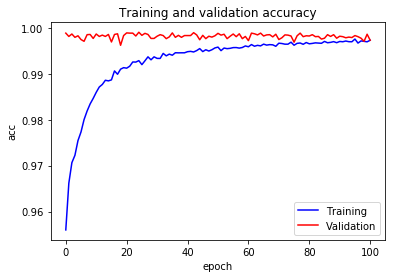

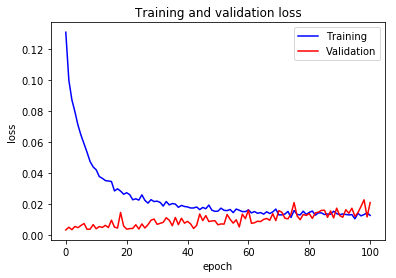

In [0]:
#Evaluation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs2 = range(len(acc))
 
plt.plot(epochs2, acc, 'b', label='Training')
plt.plot(epochs2, val_acc, 'r', label='Validation')
plt.title('Training and validation accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend()
 
plt.figure()
 
plt.plot(epochs2, loss, 'b', label='Training')
plt.plot(epochs2, val_loss, 'r', label='Validation')
plt.title('Training and validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
 
plt.show()

In [0]:
from sklearn.metrics import average_precision_score,precision_recall_curve
from sklearn.utils.fixes import signature
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [0]:
from tensorflow.keras.models import load_model

In [0]:
path = 'e-res/best_model.hdf5'
criticality_network_load = load_model(path) #<----- The Model

In [0]:
np_target_test_y = np.load('e-res/target_test_y.npy')
np_corpora_test_x = np.load('e-res/corpora_test_x.npy')

In [0]:
score = criticality_network_load.evaluate(np_corpora_test_x, np_target_test_y, verbose=1)

11539/11539 [==============================] - 3s 247us/sample - loss: 0.1313 - accuracy: 0.9736


In [0]:
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.13130904127952253
Test accuracy: 0.9735679


In [0]:
history_predict = criticality_network_load.predict(x=np_corpora_test_x)
history_predict

array([[1.0000000e+00, 9.7539722e-17],
       [9.3283859e-07, 9.9999905e-01],
       [1.0000000e+00, 2.0519539e-29],
       ...,
       [2.1023639e-04, 9.9978977e-01],
       [9.9999917e-01, 7.8283227e-07],
       [5.1913088e-07, 9.9999952e-01]], dtype=float32)

In [0]:
inferred_data = pd.DataFrame(history_predict,columns=list('AB'))
target_data = pd.DataFrame(np_target_test_y,columns=list('LN'))
data = target_data.join(inferred_data)

In [0]:
data.head()

,L,N,A,B
0,1,0,1.000000e+00,9.753972e-17
1,0,1,9.328386e-07,9.999990e-01
2,1,0,1.000000e+00,2.051954e-29
3,0,1,1.231208e-04,9.998769e-01
4,1,0,1.000000e+00,3.948549e-15


In [0]:
y_true = list(data['L'])
y_score= list(data['A'])
average_precision = average_precision_score(y_true, y_score)

In [0]:
print('Average precision-recall score: {0:0.2f}'.format(average_precision))

Average precision-recall score: 1.00


In [0]:
precision, recall, thresholds = precision_recall_curve(y_true, y_score)

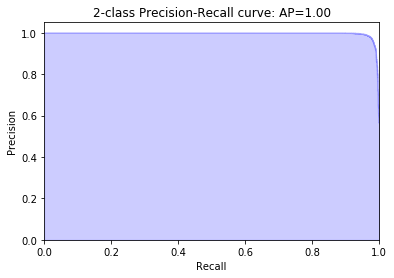

In [0]:
# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

In [0]:
#ROC Curve (all our samples are balanced)
auc = roc_auc_score(y_true, y_score)
print('AUC: %.3f' % auc)

AUC: 0.995
